# Epileptic Seizure Classification with Bi-LSTM & Attention-Layer
This notebook contains the classification of time series EEG data for the detection of epileptic seizures based on the preprocessed CHB-MIT Scalp EEG Database using a neural network with bidirectional LSTM and an attention layer. <br>
The codes is structured as followed:
1. [Imports](#1-imports)
2. [Load Preprocessed Dataset](#2-load-preprocessed-dataset)
3. [Split Dataset](#3-split-dataset)
4. [Normalize Dataset](#4-normalize-dataset)
5. [Bi-LSTM Model with Attention-Layer](#5-autoencoder) <br>
5.1 [Define Neural Network-Model](#52-define-autoencoder-model) <br>
5.2 [Compile Neural Network-Model]() <br>
5.3 [Train Neural Network]() <br>
6. [Validate Results](#6-validate-results)
7. [Explain Model with SHAP]()
8. [Conclusions](#8-conclusion)

## 1. Imports
Import requiered libraries. <br>
External packages can be installed via the `pip install -r requirements.txt` command or the notebook-cell below.

In [ ]:
! pip install -r ../requirements.txt

In [1]:
# Import built-in libraries
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # Suppress SHAP warnings

# Import datascience libraries
import numpy as np

# Import preprocessing-libraries, classification metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from imblearn.metrics import geometric_mean_score

# Import visualization libraries
import plotly.graph_objects as go
from prettytable import PrettyTable

# Import neural network framework & layers
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Attention, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import L1L2

# Import explainability library
import shap

## 2. Load Preprocessed Dataset
The preprocessed dataset, that was created with the notebook `00_Preprocessing.ipynb`, is loaded and the numpy Arrays for the features and labels are extracted. Due to the capability of the neural network to process the temporal dependencies in combination with a high sensibilty, the dataset with the max-label generation is chosen.<br>
To enshure a functional distribution of the classes in the dataset, the classes with the respective amounts are plotted.

In [2]:
dataset = np.load('../00_Data/Processed-Data/classification_dataset_max.npz') # Load compressed numpy array
X = dataset["features"] # Extract feature-array from compressed file
y = dataset["labels"] # Extract label-array from compressed file

In [3]:
print("Shapes: \n X:", X.shape, "y:", y.shape)
print("Unique Values:", np.unique(y, return_counts=True))

Shapes: 
 X: (16999, 1000, 24) y: (16999, 1)
Unique Values: (array([0, 1], dtype=int8), array([9375, 7624]))


## 3. Split Dataset
In order to validate and test the trained classifier, the dataset must be split into a `train`, `test`, and `validation` subset. <br>
To preserve an equal distribution within each split, the `stratify`-option is enabled.

In [4]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=np.ravel(y), random_state=254)
X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=True, stratify=np.ravel(y_rest), random_state=865)

## 4. Normalize Dataset
When working with neural networks, it is imperative to normalize the data before training, testing and validation. This enshures a faster training, avoids numerical instablities and provides a better generalization of the neural network over different data. However with EEG-data, there are additional requirements due to the different characteristics and value-ranges of the individual channels. Therefore, the normalization is done channel by channel based on the training-subset and applied on the test- and validation-split.

In [5]:
def normalize_features(X_train:np.ndarray, X_test:np.ndarray, X_val:np.ndarray, use_standard_scaler:bool=False) -> tuple:
    if(use_standard_scaler):
        scaler = StandardScaler() # Create Z-Score normalizer
    else:
        scaler = MinMaxScaler() # Create Min-Max normalizer
    X_train_norm = np.zeros(shape=(X_train.shape), dtype='float32') # Create empty array for normalized train-data
    X_test_norm = np.zeros(shape=(X_test.shape), dtype='float32') # Create empty array for normalized test-data
    X_val_norm = np.zeros(shape=(X_val.shape), dtype='float32') # Create empty array for normalized val-data
    for feature_col in range(X_train.shape[2]): # Iterate over features in dataset
        X_train_norm[:,:,feature_col] = scaler.fit_transform(X_train[:,:,feature_col]) # Fit and apply normalizer on current feature in train subset
        X_test_norm[:,:,feature_col] = scaler.transform(X_test[:,:,feature_col]) # Apply normalizer on current feature in test subset
        X_val_norm[:,:,feature_col] = scaler.transform(X_val[:,:,feature_col]) # Apply normalizer on current feature in val subset
    return X_train_norm, X_test_norm, X_val_norm

In [6]:
X_train_norm, X_test_norm, X_val_norm = normalize_features(X_train, X_test, X_val, True)

## 5. Bi-LSTM Model with Attention Layer
This section contains the definition, compilation & training of the neural network. The data is introduced into the neural network via an Input-layer, followed by two bidirectional LSTM layers which process the data respecitvely with and against the direction of time. The next layer is the attention layer. Following, the outputs are flattend in order to perform a binary classification of the entire time series. The regression task is performed by two Dense layers which end with an sigmoid activation function which limits the ouput between 0 and 1. The results can be rounded to the nearest integer in order to calculate the desired metrics.

### 5.1 Define Neural Network-Model
The neural network is build as described above. To prevent overfitting during the training, **Dropout** layers are added to the model. In addition, an **L1L2** regularization is introduced to limit the values of the kernel. **Adam** is used as the optimizer and the **binary crossentropy** used for the loss function.

*Note: This project was build on M1 mac. To enshure best performance, the legacy version of the Adam optimizer was used. This can be changed when using windows or newer Versions of Tensorflow!*

In [7]:
def build_and_compile_model(train_shape:tuple, initial_lr:float=0.0001):
    inputs = Input(shape=(train_shape[1], train_shape[2]))
    bilstm1 = Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer=L1L2(0, 0.0015)))(inputs)
    do1 = Dropout(0.5)(bilstm1)
    bilstm2 = Bidirectional(LSTM(32, return_sequences = True, kernel_regularizer=L1L2(0, 0.0015)))(do1)
    att = Attention(32)([bilstm2, bilstm2])
    flat = Flatten()(att)
    d1 = Dense(128, kernel_regularizer=L1L2(0, 0.0015))(flat)
    do3 = Dropout(0.5)(d1)
    d2 = Dense(8, kernel_regularizer=L1L2(0, 0.0001))(do3)
    outputs = Dense(1, activation='sigmoid')(d2)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=initial_lr)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

### 5.2 Compile Neural Network-Model
In order to train the neural network, the model defined in the previous step must be compiled. Furthermore, two **callbacks** are defined: **Early Stopping** and a **dynamic Learning Rate**. Both callbacks monitor the validation loss and stop the fitting process after a defined number of epochs without any improvement or reduce the learing rate to enable better results. Finally, the model is plottet to visualize the structure, number of parameters and enable the detection of errors in the definition.

In [8]:
model = build_and_compile_model(X_train.shape, 0.0001)

earlystopper = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000001, verbose=1, cooldown=10)

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 24)]   0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 1000, 128)    45568       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1000, 128)    0           ['bidirectional[0][0]']          
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 1000, 64)    41216       ['dropout[0][0]']                
 )           

### 5.3 Fit Neural Network-Model
Fitting the neural network stands for the training process of the weights and bias of each layer to enable good predictions. The normalized training data is used for the training step and a validation is performed after every epoch via the normalized validation split to detect and prevent overfitting. After training, the progression of the training and validation loss is visualized for the easy visualization of the fit-process and further detection of overfitting or other issues during the training. Finally, the model is saved as an .h5 file to be able to load the model an/or weights during later testing without new training.

In [10]:
history = model.fit(
    X_train_norm, 
    y_train, 
    epochs=500, 
    batch_size=50,
    validation_data=(X_val_norm, y_val),
    verbose=1, 
    callbacks=[earlystopper, reduce_lr]
)

Epoch 1/500
204/204 [==============================] - 80s 391ms/step - loss: 0.9776 - binary_accuracy: 0.8956 - val_loss: 0.9835 - val_binary_accuracy: 0.8856 - lr: 1.0000e-04
Epoch 2/500
204/204 [==============================] - 80s 391ms/step - loss: 0.8823 - binary_accuracy: 0.9121 - val_loss: 0.9224 - val_binary_accuracy: 0.8853 - lr: 1.0000e-04
Epoch 3/500
204/204 [==============================] - 79s 388ms/step - loss: 0.8169 - binary_accuracy: 0.9154 - val_loss: 0.8226 - val_binary_accuracy: 0.9115 - lr: 1.0000e-04
Epoch 4/500
204/204 [==============================] - 80s 393ms/step - loss: 0.7569 - binary_accuracy: 0.9198 - val_loss: 0.7728 - val_binary_accuracy: 0.9132 - lr: 1.0000e-04
Epoch 5/500
204/204 [==============================] - 80s 392ms/step - loss: 0.6991 - binary_accuracy: 0.9289 - val_loss: 0.7279 - val_binary_accuracy: 0.9156 - lr: 1.0000e-04
Epoch 6/500
204/204 [==============================] - 79s 388ms/step - loss: 0.6532 - binary_accuracy: 0.9344 - va

In [11]:
fig = go.Figure(
    data = [
        go.Scatter(y=history.history['loss'], name="train"),
        go.Scatter(y=history.history['val_loss'], name="val"),
    ],
    layout = {"yaxis": {"title": "Loss [Binary Crossentropy]"}, "xaxis": {"title": "Epoch"}, "title": "Model Loss over Epochs"}
)

fig.show()

In [8]:
# model.save('../99_Assets/01_Saved Models/01_bi_lstm.h5')
model = tf.keras.models.load_model('../99_Assets/01_Saved Models/01_bi_lstm.h5')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



## 6. Validate Results
To ensure correct training without overfitting and to demonstrate the generalizability of the model, a validation step is performed last. The test subset, which was not seen by the neural network during training, serves as the data basis for this. Therefore, the obtained results can be used as a representation of the generalistic predictive ability of the model. Since, depending on the data set, there may be an inequality in the distribution of the classes, the accuracy is not used as the discriminating metric. 

The F1 score, G-Mean, the AUC of the ROC both as well as the basic Precision and Recall are calculated in the following section.

In [9]:
y_test_predictions = model.predict(X_test_norm)
y_test_predictions = (y_test_predictions >= 0.5).astype(int)
f1score = f1_score(y_test, y_test_predictions)
gm = geometric_mean_score(y_test, y_test_predictions, average="binary")
auc = roc_auc_score(y_test, y_test_predictions, average="weighted")
precision = precision_score(y_test, y_test_predictions)
recall = recall_score(y_test, y_test_predictions)

2023-07-02 01:42:39.604190: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-02 01:42:40.013635: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


107/107 [==============================] - 11s 92ms/step


In [15]:
data = [["F1-Score", "G-Mean", "AUC", "Precision", "Recall"], [f1score, gm, auc, precision, recall]]
table = PrettyTable(data[0])
table.add_rows(data[1:])
print(table)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|      F1-Score      |       G-Mean       |        AUC         |     Precision      |       Recall       |
+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0.9582374219006906 | 0.9619492051163844 | 0.9619715846994534 | 0.9610817941952506 | 0.9554098360655737 |
+--------------------+--------------------+--------------------+--------------------+--------------------+


## 7. Explain Model with SHAP
Due to the implicit training of the neural network, it is not possible to trace the exact operation of the classification. For this reason, neural networks are also referred to as black box functions. However, an understanding of the functionality is necessary to understand the limitations of the developed model as well as its limitations. This is particularly important in the environment of health data in order to avoid errors in the application or treatment. Furthermore, when classifying EEG data for the detection of epileptic seizures, a detection of the triggering electrodes can be used to narrow down the locality of the seizure in the brain. One way of fulfilling these requirements is the use of explanatory models, which can approximate the functioning of the neural network on the basis of interfering input and output values. A widely used library is SHAP, which is based on a cooperative game theory approach. The library allows visualization of the respective factors for each prediction as well as a cumulative analysis of the importance of each feature.

*Note: At the time of development, SHAP does not support Tensorflow v2.X. Because of this issue, the v2 behaviour must be disabled and the model rebuild. However, the already trained weights can be loaded via the previousely saved model to prevent additional training. If further development fixes this issue, the following notebook-cell can be removed and the trained model directly loaded.*

In [8]:
tf.compat.v1.disable_v2_behavior() # Disable Tensorflow v2 behaviour
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [9]:
model_v1 = build_and_compile_model(X_train.shape, 0.0001) # Rebuild untrained model with Tensorflow v2 behaviour (without graph execution)
model_v1.load_weights(filepath="../99_Assets/01_Saved Models/01_bi_lstm.h5") # Load saved weights from trained model

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2023-07-02 01:32:16.037377: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-02 01:32:16.064931: W tensorflow/c/c_api.cc:300] Operation '{name:'bidirectional_1/backward_lstm_1/lstm_cell_5/kernel/Assign' id:396 op device:{requested: '', assigned: ''} def:{{{node bidirectional_1/backward_lstm_1/lstm_cell_5/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bidirectional_1/backward_lstm_1/lstm_cell_5/kernel, bidirectional_1/backward_lstm_1/lstm_cell_5/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [10]:
shap.initjs()

### 7.1 Create a subset of the training data
Due to the complex calculations involved, the creation of the explainer model is very time-consuming and computationally expensive. To ensure a reliable explanation and relative resource requirement, a random subset is formed from the data.

In [11]:
n = 100 # Number of samples to extract
index = np.random.choice(X_train_norm.shape[0], n, replace=False) # Get subset of indices from train data
X_train_sub = X_train_norm[index] # Create subset of train data based on random indices

### 7.2 Create Explainer Model
Based on the subset created in the last step, the explainer model can now be created. Since the classifier is a neural network, the deep explainer of the SHAP library is used. <br>
In the next step, the training data is used to create an array of so-called Shapley values, which represent the respective influence of the input features on the result.

**Warning: The creation of the shap-values is due to the extensive size of the demonstration dataset a very complex process and might, depending on the used hardware, take up to multiple hours. For demonstration purposes, the values of the demonstrated model where saved and can be loaded to enable a quick generation of the SHAP-plots.**

In [12]:
explainer = shap.DeepExplainer(model_v1, X_train_sub) # Create deep explainer model based on subset using the rebuild v1 Tensorflow model

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [13]:
shap_values = explainer.shap_values(X_test_norm[:30], check_additivity=False) # Create shap-values; WARNING: EXECUTION MIGHT TAKE 1+ HOURS! 

### 7.3 Force-Plot for Explanation of Classification Result of one Time-Step
The force plot visualizes the influence of the individual input features on the result. It should be noted that the classification by the neural network represents a regression whose value lies between 0 and 1. If the result is greater than 0.5, the positive class is assigned and otherwise the negative class. 

In [23]:
i = 3 # Index of Sample
j = 600 # Index of time step

shap.force_plot(explainer.expected_value[0], shap_values[0][i][j])

### 7.4 Summary-Plot for Feature Importance & Feature Influence
The summary plot aggregates the importance and influence of each feature across the entire dataset. The information can be used for feature selection or identifying the influence of the inputs on the result. To do this, the dataset must be transformed because only two-dimensional data can be used.

In [28]:
shap_values_2D = shap_values[0].reshape(-1,shap_values[0].shape[2])
X_test_2D = X_test_norm[:30].reshape(-1,shap_values[0].shape[2])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


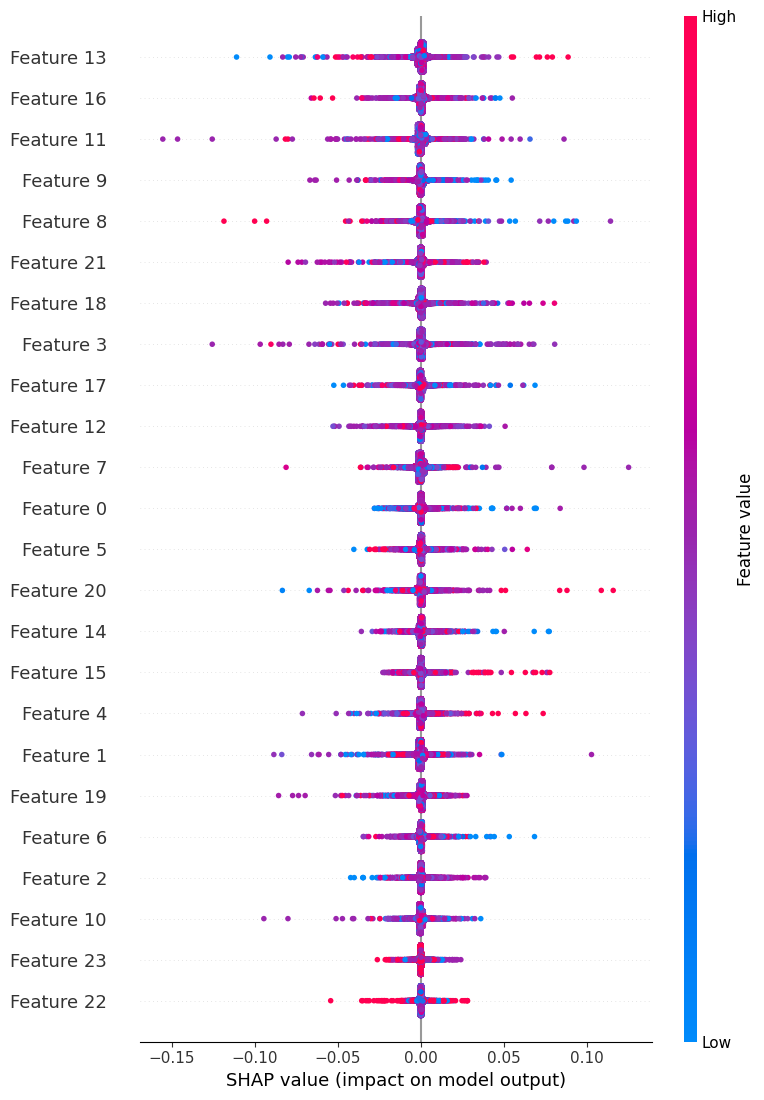

In [31]:
shap.summary_plot(shap_values_2D, X_test_2D, max_display=1000)

## 8. Conclusion
The goal of this notebook was to demonstrate binary classification of Time Series EEG data for epileptic seizure detection using Bi-LSTM and Attention layers. To begin, the preprocessed dataset was loaded, split into a train, test, and validation subset, and normalized. The defined model used bidirectional LSTM layers followed by an attention layer as well as dense layers for regression. In addition, dropout as well as L1L2 regularization was applied to avoid overfitting. During training, the learning rate was dynamically adjusted and the process was stopped in the absence of learning success. After training, the resulting model was validated with unused data and its generalizability was tested. In addition, the black box function was analyzed by the SHAP library and visualizations were provided to explain its operation. 

In general, the procedure proved to be very effective and an F1 score of XX was achieved. Moreover, the explanations can be used for the explanation of the neural network predictions as well as the analysis of the present epilleptic seizures. A final comparison of all methodologies will be made in Notebok XYZ.